## module 

In [1]:
! pip install numpy

In [2]:
!pip install tensorflow-macos scikit-learn pandas matplotlib seaborn opencv-python 

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, ResNet50, DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

/Users/vnlt/PROJECT/1st-experimet-tf/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## dataset 🔧

In [6]:
# dataset split
import os, shutil
from sklearn.model_selection import train_test_split

# 🔧 데이터셋 원본 경로 (클래스별 디렉토리만 존재)
ORIGINAL_DATASET_DIR = "/Volumes/PortableSSD/data"  # 🔧 수정 필요
BASE_OUTPUT_DIR = "/Users/vnlt/PROJECT/1st-experimet-tf/split_dataset/No-1" # 🔧 분할된 결과 저장 경로

# 비율 설정
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15

In [7]:


# 1. 각 클래스별 이미지 개수 파악
class_image_counts = []
for cls in os.listdir(ORIGINAL_DATASET_DIR):
    cls_path = os.path.join(ORIGINAL_DATASET_DIR, cls)
    if not os.path.isdir(cls_path):
        continue
    images = os.listdir(cls_path)
    class_image_counts.append(len(images))

min_count = min(class_image_counts)  # 모든 클래스 중 최소 이미지 개수

# 2. 각 클래스별로 min_count만큼만 랜덤 샘플링 후 분할
for cls in os.listdir(ORIGINAL_DATASET_DIR):
    cls_path = os.path.join(ORIGINAL_DATASET_DIR, cls)
    if not os.path.isdir(cls_path):
        continue

    images = os.listdir(cls_path)
    np.random.shuffle(images)
    images = images[:min_count]  # 최소 개수만큼만 사용

    train_imgs, temp_imgs = train_test_split(images, train_size=train_ratio)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=test_ratio/(val_ratio+test_ratio))

    for category, category_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
        save_path = os.path.join(BASE_OUTPUT_DIR, category, cls)
        os.makedirs(save_path, exist_ok=True)
        for img in category_imgs:
            shutil.copy(os.path.join(cls_path, img), os.path.join(save_path, img))

print("✅ 클래스별 동일 개수로 데이터셋 분할 완료. 경로:", BASE_OUTPUT_DIR)


✅ 클래스별 동일 개수로 데이터셋 분할 완료. 경로: /Users/vnlt/PROJECT/1st-experimet-tf/split_dataset/No-1


### Display dataset sample fuction


In [63]:
def show_images(gen):
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    
    images, labels = next(gen)

    # 예외 방지 디버깅
    if isinstance(images[0], str):
        print("❌ 이미지가 배열이 아니라 문자열(파일 경로)입니다.")
        print("예: ", images[0])
        return
    else:
        print("✅ 이미지 로딩 확인:", images[0].shape, images[0].dtype, images[0].min(), images[0].max())

    n_per_class = 10
    idx_per_class = {cls: [] for cls in range(len(classes))}
    for idx, label in enumerate(labels):
        class_idx = np.argmax(label)
        if len(idx_per_class[class_idx]) < n_per_class:
            idx_per_class[class_idx].append(idx)
        if all(len(v) == n_per_class for v in idx_per_class.values()):
            break

    total = n_per_class * len(classes)
    plt.figure(figsize=(20, 2 * len(classes)))
    plot_idx = 1
    for class_idx, idxs in idx_per_class.items():
        for i in idxs:
            plt.subplot(len(classes), n_per_class, plot_idx)
            image = images[i]
            plt.imshow(image)
            plt.title(classes[class_idx], color='blue', fontsize=12)
            plt.axis('off')
            plot_idx += 1
    plt.show()



In [36]:
# mapping preprocess per model
preprocess_map = {
    "MobileNetV2": mobilenet_preprocess,
    "EfficientNetB0": efficientnet_preprocess,
    "ResNet50": resnet_preprocess,
    "DenseNet121": densenet_preprocess
}

In [38]:
# data generators with preprocessing
def get_data_generators(model_name, data_dir, img_size=(224, 224), batch_size=HYPERPARAMS['batch_size']):
    preprocess_func = preprocess_map[model_name]
    
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_func,
        rotation_range=15,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        validation_split=0.2
    )

    val_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_func,
        validation_split=0.2
    )

    train_gen = train_datagen.flow_from_directory(
        os.path.join(data_dir, "train"),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    val_gen = val_datagen.flow_from_directory(
        os.path.join(data_dir, "train"),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    test_gen = ImageDataGenerator(preprocessing_function=preprocess_func).flow_from_directory(
        os.path.join(data_dir, "test"),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_gen, val_gen, test_gen


## base model

In [39]:
def build_model(base, input_shape, n_classes):
    input_tensor = Input(shape=input_shape + (3,))
    base_model = base(include_top=False, weights='imagenet', input_tensor=input_tensor)
    x = GlobalAveragePooling2D()(base_model.output)
    output = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model


## train

### train setting 🔧

In [58]:
# 🔧 실행할 모델 이름 설정
model_name = "ResNet50"  # 🔧 수정 필요
base_models = {
    "MobileNetV2": MobileNetV2,
    "EfficientNetB0": EfficientNetB0,
    "ResNet50": ResNet50,
    "DenseNet121": DenseNet121
}

### traing and evaluation 🔧

In [59]:
# 하이퍼파라미터 설정🔧
HYPERPARAMS = {
    'learning_rate': 1e-4,
    'batch_size': 32,
    'epochs': 30,
    'patience': 5,
    'input_shape': (224, 224),
    'experiment_id': f"{model_name}_test"
}

In [60]:
# data sample check
train_gen, val_gen, test_gen = get_data_generators(model_name, BASE_OUTPUT_DIR, batch_size=HYPERPARAMS['batch_size'])
input_shape = (224, 224)
n_classes = train_gen.num_classes

Found 1100 images belonging to 5 classes.
Found 274 images belonging to 5 classes.
Found 295 images belonging to 5 classes.


In [61]:
import glob

def count_images_per_split(base_dir):
    splits = ['train', 'val', 'test']
    data = []
    for split in splits:
        split_dir = os.path.join(base_dir, split)
        if not os.path.exists(split_dir):
            continue
        for cls in sorted(os.listdir(split_dir)):
            cls_dir = os.path.join(split_dir, cls)
            if not os.path.isdir(cls_dir):
                continue
            img_count = len(glob.glob(os.path.join(cls_dir, '*')))
            data.append({'Split': split, 'Class': cls, 'Image Count': img_count})
    return pd.DataFrame(data)

df_counts = count_images_per_split(BASE_OUTPUT_DIR)
display(df_counts.pivot(index='Class', columns='Split', values='Image Count').fillna(0).astype(int))


Split,test,train,val
Class,,,
Bacterial-spot,59,275,59
Healthy,59,275,59
PMMoV,59,275,59
Powdery-mildew,59,275,59
TSWV,59,275,59


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..127.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.68..89.32].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..126.221].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-115.68..91.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-103.939..125.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..118.221].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-122.68..108.221].
Clipping input data to

✅ 이미지 로딩 확인: (224, 224, 3) float32 -120.68 103.061


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-122.68..104.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-116.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-122.68..105.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-112.68..142.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-115.68..134.22101].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-119.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-122.68..111.221].
Clipping input dat

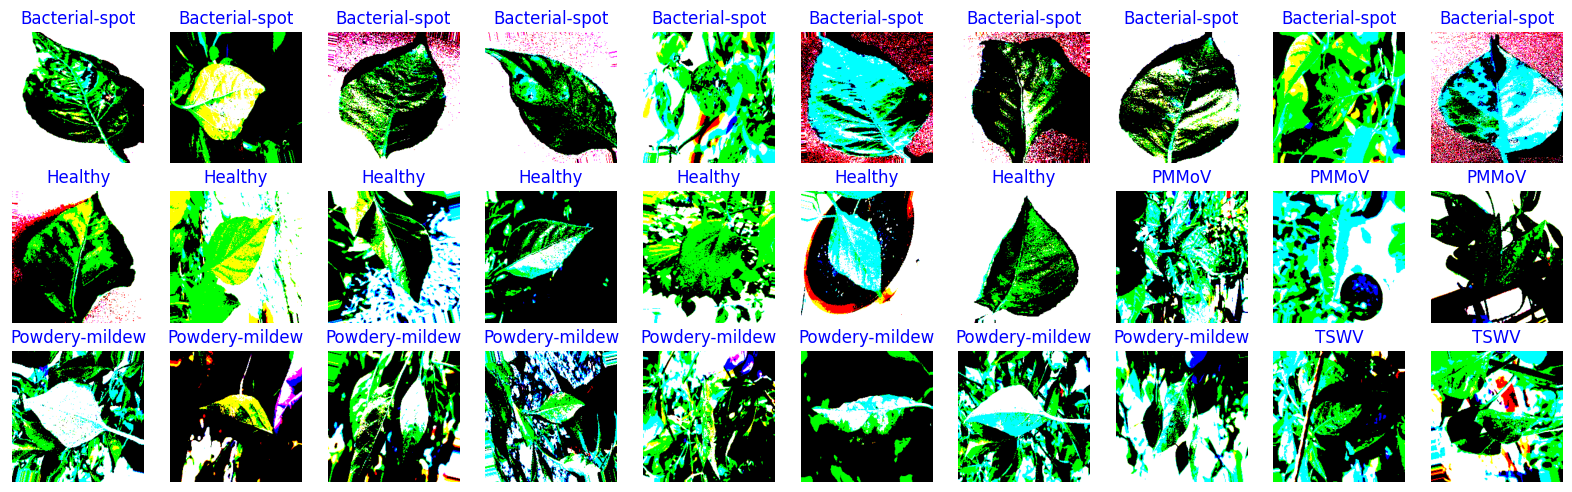

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-118.68..109.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-115.68..137.22101].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-101.939..118.32].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-108.68..135.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-113.68..82.221].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-99.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-108.68..118.061].
Clipping input data 

✅ 이미지 로딩 확인: (224, 224, 3) float32 -123.68 138.22101


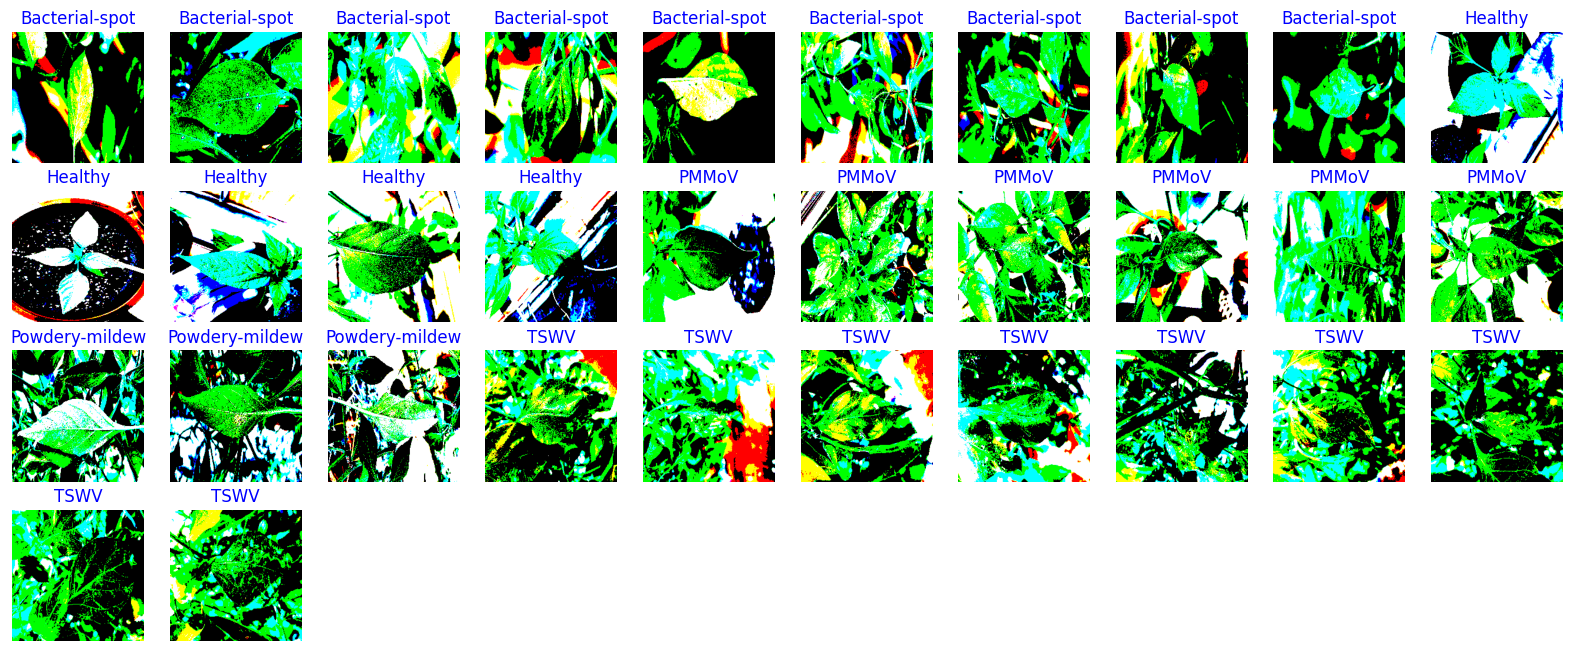

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..143.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..144.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..138.22101].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-114.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..138.22101].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..138.22101].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..139.061].
Clipping input

✅ 이미지 로딩 확인: (224, 224, 3) float32 -123.68 143.061


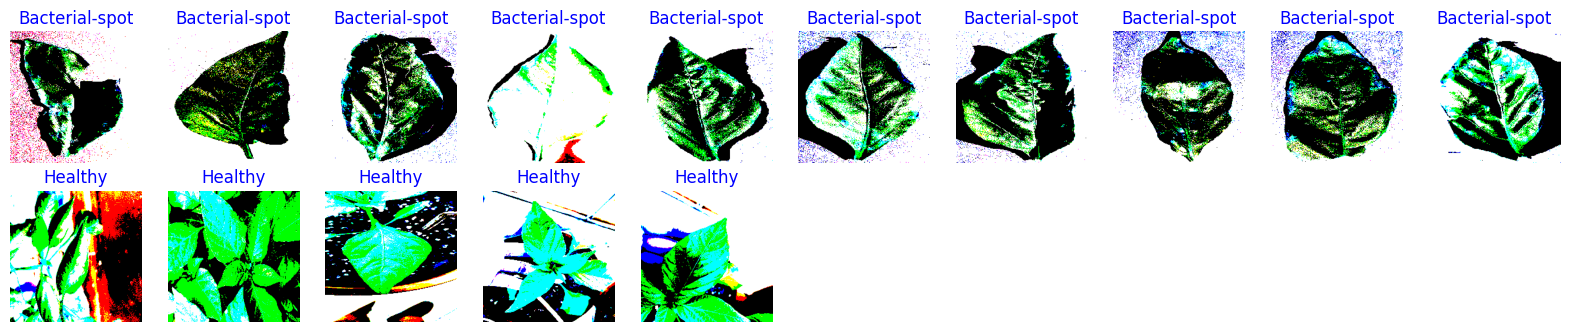

In [64]:
show_images(train_gen)
show_images(val_gen)
show_images(test_gen)

In [67]:
model = build_model(base_models[model_name], input_shape, n_classes)
model.compile(optimizer=Adam(HYPERPARAMS['learning_rate']), loss='categorical_crossentropy', metrics=['accuracy'])

In [68]:

# 콜백 설정
ckpt = ModelCheckpoint(f'{model_name}.h5', save_best_only=True, monitor='val_accuracy')
early = EarlyStopping(patience=HYPERPARAMS['patience'], restore_best_weights=True)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 23,544,837 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [72]:

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=HYPERPARAMS['epochs'],
    callbacks=[ckpt, early]
)


/Users/vnlt/PROJECT/1st-experimet-tf/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Users/vnlt/PROJECT/1st-experimet-tf/.venv/lib/python3.9/site-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1/30
 3/35 ━━━━━━━━━━━━━━━━━━━━ 2:31 5s/step - accuracy: 0.1580 - loss: 1.8693

KeyboardInterrupt: 

In [ ]:
# 평가
test_gen.reset()
pred_probs = model.predict(test_gen)
y_true = test_gen.classes
y_pred = np.argmax(pred_probs, axis=1)
class_names = list(test_gen.class_indices.keys())

report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
cm = confusion_matrix(y_true, y_pred)


## visualization, result save

In [ ]:
# confusion matrix, train history, classification report
def plot_confusion_matrix(cm, class_names, title, save_path=None):
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    if save_path:
        plt.savefig(save_path)
    plt.show()

def plot_train_history(history, title_prefix, save_path=None):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title_prefix} Accuracy')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title_prefix} Loss')
    plt.legend()
    if save_path:
        plt.savefig(save_path)
    plt.show()

def save_results(model_name, history, cm, class_names, report):
    result_dir = f"result/{HYPERPARAMS['experiment_id']}"
    os.makedirs(result_dir, exist_ok=True)

    plot_confusion_matrix(cm, class_names, title=f'{model_name} Confusion Matrix',
                          save_path=os.path.join(result_dir, "confusion_matrix.png"))
    plot_train_history(history, title_prefix=model_name,
                       save_path=os.path.join(result_dir, "accuracy_loss.png"))
    with open(os.path.join(result_dir, "classification_report.json"), "w") as f:
        json.dump(report, f, indent=4)


In [ ]:
# top-3 accuracy 🔧

def show_top_misclassified(y_true, y_pred, probs, class_names, generator, model_name, save_dir, top_n=3):
    error_indices = np.where(y_true != y_pred)[0]
    confidence_errors = probs[error_indices, y_pred[error_indices]]
    sorted_idx = error_indices[np.argsort(confidence_errors)[-top_n:][::-1]]

    os.makedirs(save_dir, exist_ok=True)

    for i, idx in enumerate(sorted_idx):
        img_path = generator.filepaths[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(
            f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}\nConf: {confidence_errors[i]:.2f}"
        )
        plt.axis('off')

        save_path = os.path.join(save_dir, f"misclassified_{i+1}.png")
        plt.savefig(save_path)
        plt.show()

    print(f"✅ 오분류 top-{top_n} 이미지 저장 완료: {save_dir}")


In [ ]:
# results 
save_results(model_name, history, cm, class_names, report)
show_top_misclassified(
    y_true=y_true,
    y_pred=y_pred,
    probs=pred_probs,
    class_names=class_names,
    generator=test_gen,
    model_name=model_name,
    save_dir=f"result/{HYPERPARAMS['experiment_id']}",
    top_n=3
)
print(f"\u2705 저장 완료: result/{HYPERPARAMS['experiment_id']}")